In [1]:
import os
os.chdir("/home/canyon/hackday-q2-2024-open-earth-foundation")
from src.utils import *
import censusdis.data as ced
import matplotlib.pyplot as plt
alber_eq_us = "EPSG:5070"

/nas/local/simscripts/canyon/.nest/canyon_nest/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
city_gdf = load_data_from_ts3("Geometries/US_city_geometries.geojson")

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)
Cannot find header.dxf (GDAL_DATA is not defined)


In [20]:
fuel_sales = load_data_from_ts3("DOT Fuel Sales/monthly_fuel_sales_by_month_2023.csv")
fuel_sales = fuel_sales.reset_index()
for col in fuel_sales.columns:
    if col != "State":
        fuel_sales[col] = fuel_sales[col].astype(str).str.replace(',', '').astype(int)

In [28]:
trips = load_data_from_ts3("BTS Trips/Trips_by_Distance_20240523.csv")
trips["Date"] = pd.to_datetime(trips["Date"])

In [101]:
trips_2023 = trips[trips.Date.dt.year == 2023]

In [102]:
#trips_2023.fillna(0, inplace = True)

In [109]:
trips_state = trips_2023.query("Level == 'State'").reset_index()

multiplication_dict = {'Number of Trips <1' : 0.5, 'Number of Trips 1-3' : 2,
                       'Number of Trips 3-5' : 4,
       'Number of Trips 5-10' : 7, 'Number of Trips 10-25' : 13,
       'Number of Trips 25-50' : 37, 'Number of Trips 50-100' : 75,
       'Number of Trips 100-250' : 175, 'Number of Trips 250-500' : 375,
       'Number of Trips >=500' : 600}

trips_state["month"] = trips_state.Date.dt.month_name()

trips_state_month = trips_state.groupby(["State Postal Code", "month"])[list(multiplication_dict.keys())].sum().reset_index()

for key in multiplication_dict:
    trips_state_month[key + "_miles"] = trips_state_month[key] * multiplication_dict[key]

trips_state_month["total_trip_miles"] = trips_state_month[trips_state_month.columns[trips_state_month.columns.str.endswith("miles")]].sum(axis = 1)

In [114]:
trips_state_month[["State Postal Code", "month", "total_trip_miles"]]

,State Postal Code,month,total_trip_miles
0,AK,April,8.689321e+08
1,AK,August,9.101131e+08
2,AK,December,8.610540e+08
3,AK,February,8.131082e+08
4,AK,January,9.009081e+08
...,...,...,...
607,WY,March,1.012557e+09
608,WY,May,1.085158e+09
609,WY,November,1.034470e+09
610,WY,October,1.082055e+09


In [120]:
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

In [123]:
fuel_sales_monthly = fuel_sales.melt(id_vars = "State").rename({"variable" : "month", "value" : "total_fuel", "State" : "state"}, axis = 1)

In [140]:
fuel_state_2023 = fuel_sales_monthly.groupby("state")["total_fuel"].sum().reset_index()
write_to_ts3(fuel_sales_monthly, "DOT Fuel Sales/state_sales_month.csv")
write_to_ts3(fuel_state_2023, "DOT Fuel Sales/state_sales_23.csv")

In [124]:
trips_state_trim = trips_state_month[["State Postal Code", "month", "total_trip_miles"]]
trips_state_trim["state"] = trips_state_trim["State Postal Code"].map(state_dict)

/tmp/ipykernel_1611130/2853822821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_state_trim["state"] = trips_state_trim["State Postal Code"].map(state_dict)


In [141]:
write_to_cs3(trips_state_trim, "")

,State Postal Code,month,total_trip_miles,state
0,AK,April,8.689321e+08,Alaska
1,AK,August,9.101131e+08,Alaska
2,AK,December,8.610540e+08,Alaska
3,AK,February,8.131082e+08,Alaska
4,AK,January,9.009081e+08,Alaska
...,...,...,...,...
607,WY,March,1.012557e+09,Wyoming
608,WY,May,1.085158e+09,Wyoming
609,WY,November,1.034470e+09,Wyoming
610,WY,October,1.082055e+09,Wyoming


In [128]:
trips_fuel = trips_state_trim.merge(fuel_sales_monthly)
trips_fuel.head()

,State Postal Code,month,total_trip_miles,state,total_fuel
0,AK,April,868932134.5,Alaska,37577784
1,AK,August,910113056.0,Alaska,59220896
2,AK,December,861054009.5,Alaska,36414758
3,AK,February,813108174.0,Alaska,34442446
4,AK,January,900908105.0,Alaska,37253959


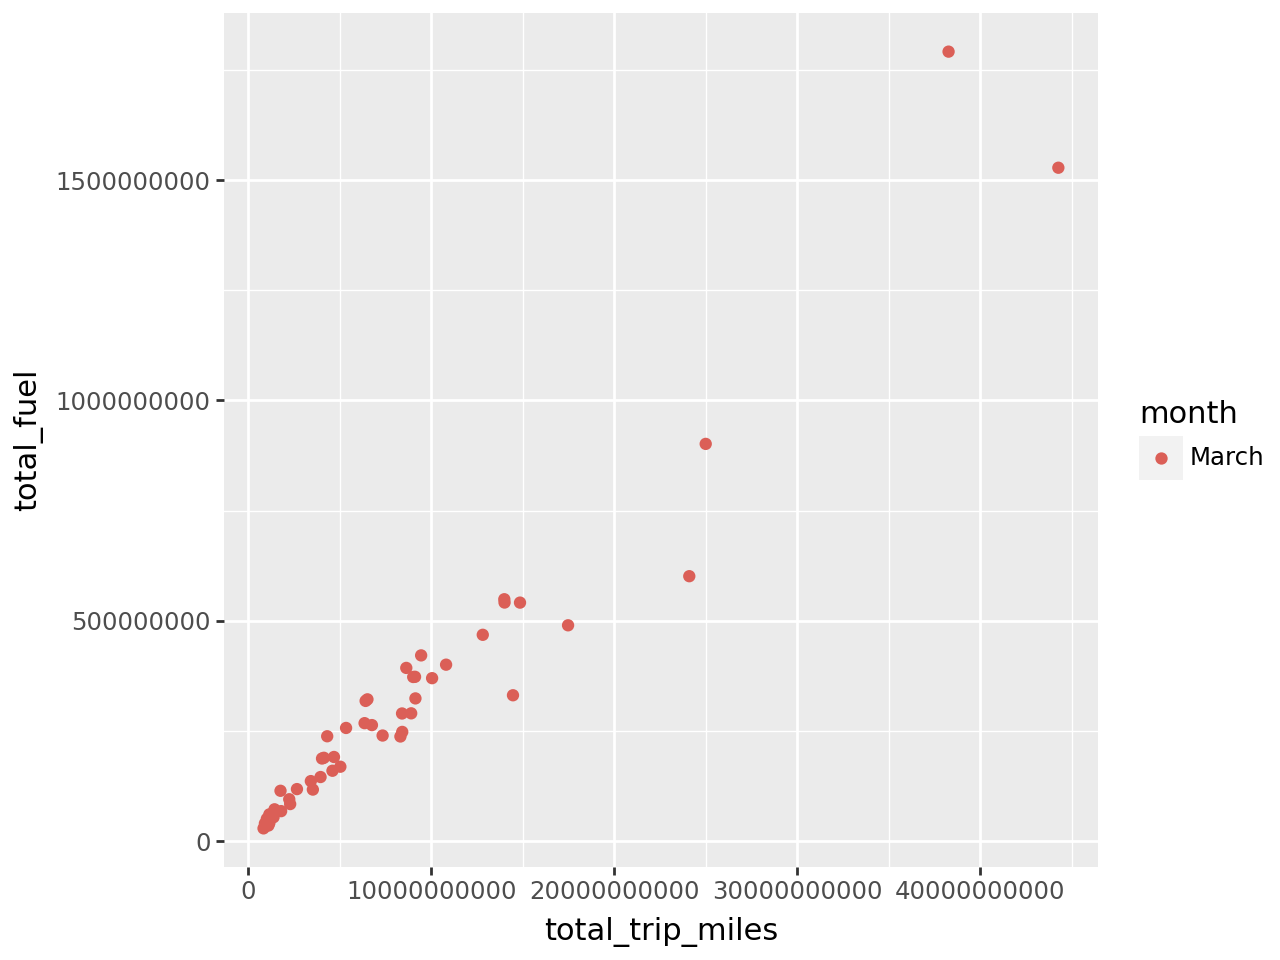

In [133]:
from plotnine import *

(ggplot(trips_fuel.query('month == "March"'), aes(x = "total_trip_miles", y = "total_fuel", color = "month"))) + geom_point() 